In [87]:
from rdkit import Chem 
from rdkit.Chem import Draw 
from ipywidgets import interact, interactive, fixed # For interactive display of conformers
from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim 
import pandas as pd 
import matplotlib.pyplot as plt # For making scatter plots 
import numpy as np # editing plots and coefficient correlation 
import scipy.stats as ss # For ranking data 
from scipy.stats import spearmanr 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# Opening active file 
refSmiles_ac = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_ace_actives.dat', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES']) 
# Opening decoy file 
refSmiles_dc = pd.read_csv('/Users/yada/Documents/UCL/Dissertation/benchmarking_platform-master/compounds/DUD/cmp_list_DUD_ace_decoys_yada.csv', sep='\t', usecols=['# Mol_Title', 'ID', 'SMILES']) #create dataframe by moving from .dat to .csv

# Identifying which smiles are active or decoy 
refSmiles_ac['Active_NotActive'] = 1
refSmiles_dc['Active_NotActive']=0

# Combining two files together 
# Putting the acitve and decoy files together 
newsmiles = pd.concat([refSmiles_ac,refSmiles_dc], ignore_index=True)
# Removing duplicates 
newlist = newsmiles.drop_duplicates(subset='SMILES', keep='first')
# Adding Hydrogens to the smile strings to allow alingment and calculations 
refMols=[Chem.AddHs(Chem.MolFromSmiles(x)) for x in newlist["SMILES"]]


In [ ]:
# Take the first 10 molecules as probe molecules 

prbMol = []
prbSmile = newlist['SMILES'][:2]
for i in prbSmile:
    prbSmileH=Chem.AddHs(Chem.MolFromSmiles(i)) 
    prbMol.append(prbSmileH)

In [ ]:
count = 1 

for i in prbMol:
    simShape,simEsp=EmbedAlignScore(i,refMols,getBestESP=False,prbNumConfs = 10,refNumConfs = 10,prbCharge = [],refCharges = [],metric = "carbo",integrate = "gauss",partialCharges = "gasteiger") 
    
    # adding parameters into csv file 
    data = {'Mol_Title':newsmiles['# Mol_Title'],'ID':newsmiles['ID'],'Smiles':newsmiles['SMILES'],'Shape':simShape,'ESP':simEsp,'Active_NotActive':newsmiles['Active_NotActive']}
    newfile = pd.DataFrame(data)
    
    # Adding new column for average values of simShape and simEsp
    newfile['Average'] = newfile[['Shape','ESP']].mean(axis=1)
    newfile.to_csv('/Users/yada/Documents/UCL/Dissertation/Benchmarking notebooks/DUD Results/ace/TestDUD_FalseESP'+str(count)+'.csv')
    
    count = count + 1

In [76]:

rocshapelist = []
rocesplist = []
rocavrlist = []

for i in range(1,11):
    file = pd.read_csv('/Users/yada/Documents/similarityDUD'+str(i)+'.csv')

# calculate AUC
    auc = roc_auc_score(file['Active_NotActive'],file['Shape'])
    rocshapelist.append(auc)
    auc = roc_auc_score(file['Active_NotActive'],file['ESP']) # better distinguising the difference between decoy and acitve - bigger value = more tpr than fpr
    rocesplist.append(auc)
    auc = roc_auc_score(file['Active_NotActive'],file['Average'])
    rocavrlist.append(auc)

data = {'Smiles':prbSmile,'ROC Shape':rocshapelist,'ROC ESP':rocesplist,'ROC Average':rocavrlist}
newfile = pd.DataFrame(data)
newfile.to_csv('/Users/yada/Documents/UCL/Dissertation/Benchmarking notebooks/DUD Results/ace/aceROCscores_False.csv')

In [77]:
# Calculating the average 

avrShape = newfile['ROC Shape'].mean()
print (avrShape)

avrEsp = newfile['ROC ESP'].mean()
print (avrEsp)

avrShapeEsp = newfile['ROC Average'].mean()
print (avrShape)

0.6618899486782222
0.7380918950324393
0.6618899486782222


In [86]:
# calculating standard deviation 

stanShape = np.std(newfile['ROC Shape'])
print (stanShape)

stanEsp = np.std(newfile['ROC ESP'])
print (stanEsp)

stanAvr = np.std(newfile['ROC Average'])
print (stanAvr)

0.05042765745310136
0.02018765348209005
0.030555078541217265


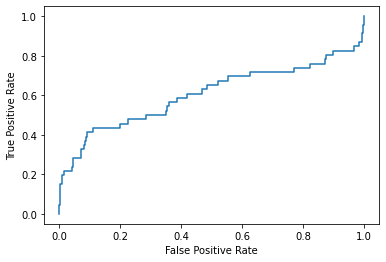

In [82]:
# Shape similairty roc curve 
fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],simShape)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()  

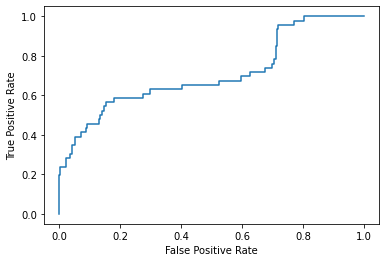

In [83]:
# Partial charges similairty roc curve 
fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],simEsp)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

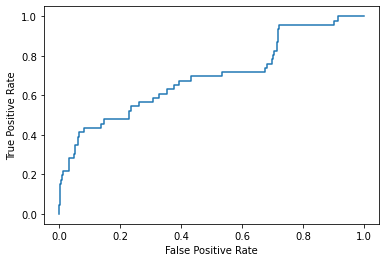

In [84]:
# Averages of shape and ESP similairty roc curve 

fpr, tpr, _ = roc_curve(newlist['Active_NotActive'],avrlist)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 